In [1]:
import tensorflow as tf
import modules.layers as tf_util
import modules.utility as util
import numpy as np
import tables
import matplotlib
%matplotlib inline
matplotlib.rcParams['font.size'] = 15
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from IPython.display import display, Javascript
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from medpy.metric.binary import hd, assd,dc,precision
# plt.style.use('ggplot')


disable_js = """
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
"""

def disable_scroll():
    display(Javascript(disable_js))
    print ("autoscrolling long output is disabled")
    
disable_scroll()

import logging
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

def reorder_contour(c):
    N = len(c)
    even_inds = np.arange(0,N,2)
    odd_inds = np.arange(1,N,2)
    
    even_points = np.asarray([c[i] for i in even_inds])
    odd_points = np.asarray([c[i] for i in odd_inds])
    
    N_even = len(even_points)
    ret = np.zeros_like(c)
    ret[:N_even] = even_points
    ret[N_even:] = np.flipud(odd_points)
    ret = ret[:-2]
    return ret.copy()

Using TensorFlow backend.


<IPython.core.display.Javascript object>

autoscrolling long output is disabled


In [2]:
mhas = open('images.txt').readlines()
mhas = [i.replace('\n','') for i in mhas]
# mhas = [i.split('/')[-1] for i in mhas]
# mhas = ['./data/'+i for i in mhas]

truths = open('truths.txt').readlines()
truths = [i.replace('\n','') for i in truths]

paths = open('paths.txt').readlines()
paths = [i.replace('\n','') for i in paths]

groups = open('groups.txt').readlines()
groups = [i.replace('\n','') for i in groups]

ct_test = open('ct_test.txt').readlines()
ct_test = [i.replace('\n','') for i in ct_test]

test_images = []
for i in range(len(mhas)):
    if any([c in mhas[i] for c in ct_test]):
        test_images.append((mhas[i],truths[i],paths[i],groups[i]))
        
print test_images

[('/home/marsdenlab/datasets/vascular_data/OSMSC0004/OSMSC0004-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0004/0004_0001/0004_0001-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0004/0004_0001/0004_0001-cm.paths', '/home/marsdenlab/datasets/vascular_data/OSMSC0004/0004_0001/0004_0001_groups-cm'), ('/home/marsdenlab/datasets/vascular_data/OSMSC0119/OSMSC0119-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0119/0119_0001/0119_0001-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0119/0119_0001/0119_0001-cm.paths', '/home/marsdenlab/datasets/vascular_data/OSMSC0119/0119_0001/0119_0001_groups-cm'), ('/home/marsdenlab/datasets/vascular_data/OSMSC0144/OSMSC0144-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0144/0144_1001/0144_1001-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0144/0144_1001/0144_1001-cm.paths', '/home/marsdenlab/datasets/vascular_data/OSMSC0144/0144_1001/0144_1001_groups-cm'), ('/home/marsdenlab/datasets/vascular_data/OSMSC0

In [5]:
#######################################################
# Get data
#######################################################
data_path = '/media/marsdenlab/Data2/datasets/DeepLofting/'
test = data_path+'test_192_ct.hdf5'
test_mr = data_path+'test_192_mr.hdf5'

CODE = 'ALL'

crop_dims = 128
SKIP = 3
if CODE == "CT":
    f_test = tables.open_file(test)
    
if CODE == "MR":
    f_test = tables.open_file(test_mr)
    
if not CODE == 'ALL':
    

    Y = np.asarray(f_test.root.Y)
    Y = Y.astype(int)
    C_truth = f_test.root.C
    
    
    META = f_test.root.meta
    

    
else:
    f_test = tables.open_file(test)
    f_test_mr = tables.open_file(test_mr)
    
    Y = np.concatenate((f_test.root.Y,f_test_mr.root.Y))
    C_truth = np.concatenate((f_test.root.C,f_test_mr.root.C))
    META = np.concatenate((f_test.root.meta,f_test_mr.root.meta))

    
    Y = Y[::SKIP]
    C_truth = C_truth[::SKIP]
    META = META[::SKIP]
Y = util.crop_center_nd(Y,crop_dims, crop_dims)
N,W,H,C = Y.shape
print len(Y)
print len(C_truth)
print Y.shape
print META.shape

19712
19712
(19712, 128, 128, 1)
(19712, 2)


In [6]:
def calc_errors(err_dict,pred_dict,c_truth,y_truth,meta,code):
    
    err_dict[code] = {}
    
    y = util.threshold(pred_dict[code]['y'],0.1).astype(int)
    c = pred_dict[code]['c']
    
    N = len(y)
    Ntruth = len(y_truth)
   
    if not N == Ntruth:
        raise RuntimeError('number of predicted and true segs does not match {},{}'.format(N,Ntruth))
    
    Nc = len(pred_dict[code]['c'])
    Nc_truth = len(c_truth)

    if not Nc == Nc_truth:
        raise RuntimeError('number of predicted and true conts does not match {},{}'.format(Nc,Nc_truth))

    print "Error calc {} y {}, y_truth {}, c {}, c_truth {}".format(code,y.shape,y_truth.shape,len(c),len(c_truth))

    #JACCARD
    err_dict[code]['jaccard'] = util.jaccard2d(y_truth,y)

    #HAUSDORF
    err_dict[code]['hausdorf'] = []
    for i in range(N):
        if np.sum(y_truth[i]) >2:
            if np.sum(y[i])>2:
                e = hd(y[i,:,:,0], y_truth[i,:,:,0], meta[i][0])
                err_dict[code]['hausdorf'].append(e)

    #ASSD
    err_dict[code]['assd'] = [] 

    for i in range(N):
        if np.sum(y_truth[i]) > 2:
            if np.sum(y[i])>2:

                e = assd(y[i,:,:,0],y_truth[i,:,:,0],meta[i][0])
                err_dict[code]['assd'].append(e)
    
                
def get_preds(pred_dict,ct_c,ct_y,mr_c,mr_y,code, TCODE):
    pred_dict[code] = {}
    if TCODE == "CT":
        pred_dict[code]['y'] = np.load(ct_y)

        pred_dict[code]['c'] = np.load(ct_c)
    if TCODE == "MR":
        pred_dict[code]['y'] = np.load(mr_y)

        pred_dict[code]['c'] = np.load(mr_c)
    
    if TCODE == "ALL":
        y_ct = np.load(ct_y)
        y_mr = np.load(mr_y)
        pred_dict[code]['y'] = np.concatenate((y_ct,y_mr))[::SKIP]
        
        c_ct = np.load(ct_c)
        c_mr = np.load(mr_c)
        pred_dict[code]['c'] = np.concatenate((c_ct,c_mr))[::SKIP]
        
    print "segs and contours for {}, y shape = {}, c shape = {}".format(code,pred_dict[code]['y'].shape,
                                                                    pred_dict[code]['c'].shape)

In [7]:
PREDS = {}
ERRORS = {}

code = 'i2ifc'
ct_c = 'i2i_conts_CT.npy'
ct_y = 'i2i_segs_CT.npy'
mr_c = 'i2i_conts_MR.npy'
mr_y = 'i2i_segs_MR.npy'

c_truth = C_truth
y_truth = Y

print len(y_truth),len(c_truth)
get_preds(PREDS, ct_c, ct_y, mr_c, mr_y, code,CODE)

#NOTE ADDING 32 BECAUSE EXTRACTED FROM CROPPED IMAGES
PREDS[code]['c'] = [c[:,:2]-64 for c in PREDS[code]['c']]
PREDS[code]['c'] = [PREDS[code]['c'][i]*META[i] for i in  range(len(C_truth))]
PREDS[code]['c'] = [reorder_contour(c) for c in PREDS[code]['c']]

print "{} shape = y {}, c {}, {}".format(code,PREDS[code]['y'].shape,len(PREDS[code]['c']),
                                         PREDS[code]['c'][0].shape)

#ERROR CALCULATION
calc_errors(ERRORS,PREDS,c_truth,y_truth,META,code)

19712 19712
segs and contours for i2ifc, y shape = (19712, 128, 128, 1), c shape = (19712,)
i2ifc shape = y (19712, 128, 128, 1), c 19712, (58, 2)
Error calc i2ifc y (19712, 128, 128, 1), y_truth (19712, 128, 128, 1), c 19712, c_truth 19712


In [8]:
code = 'i2i'
ct_c = 'i2i_vanilla_conts_ct.npy'
ct_y = 'i2i_vanilla_segs_ct.npy'
mr_c = 'i2i_vanilla_conts_mr.npy'
mr_y = 'i2i_vanilla_segs_mr.npy'

get_preds(PREDS, ct_c, ct_y, mr_c, mr_y, code,CODE)

#NOTE ADDING 32 BECAUSE EXTRACTED FROM CROPPED IMAGES
PREDS[code]['c'] = [c[:,:2]-64 for c in PREDS[code]['c']]
PREDS[code]['c'] = [PREDS[code]['c'][i]*META[i] for i in  range(len(C_truth))]
PREDS[code]['c'] = [reorder_contour(c) for c in PREDS[code]['c']]

print "{} shape = y {}, c {}, {}".format(code,PREDS[code]['y'].shape,len(PREDS[code]['c']),
                                         PREDS[code]['c'][0].shape)

#ERROR CALCULATION
calc_errors(ERRORS,PREDS,c_truth,y_truth,META,code)

segs and contours for i2i, y shape = (19712, 128, 128, 1), c shape = (19712,)
i2i shape = y (19712, 128, 128, 1), c 19712, (629, 2)
Error calc i2i y (19712, 128, 128, 1), y_truth (19712, 128, 128, 1), c 19712, c_truth 19712


In [10]:
from skimage.measure import grid_points_in_poly
if CODE == "CT":
    f_i2i3d = tables.open_file('/media/marsdenlab/Data2/datasets/DeepLofting/test_192_ct_i2i3d.hdf5')
    c3d = np.load('i2i_3d_conts_ct.npy')
    y_3d = f_i2i3d.root.X
    
if CODE == "MR":
    f_i2i3d = tables.open_file('/media/marsdenlab/Data2/datasets/DeepLofting/test_192_mr_i2i3d.hdf5')
    c3d = np.load('i2i_3d_conts_mr.npy')
    y_3d = f_i2i3d.root.X
    
if CODE == "ALL":
    f_i2i3d = tables.open_file('/media/marsdenlab/Data2/datasets/DeepLofting/test_192_ct_i2i3d.hdf5')
    c3d = np.load('i2i_3d_conts_ct.npy')
    
    f_i2i3d_mr = tables.open_file('/media/marsdenlab/Data2/datasets/DeepLofting/test_192_mr_i2i3d.hdf5')
    c3d_mr = np.load('i2i_3d_conts_mr.npy')
    
    y_3d = np.concatenate((f_i2i3d.root.X,f_i2i3d_mr.root.X))[::SKIP]
    c3d = np.concatenate((c3d,c3d_mr))[::SKIP]
code = 'i2i3d'

PREDS[code] = {}
PREDS[code]['y'] = y_3d
PREDS[code]['c'] = c3d

c_truth = C_truth
y_truth = Y

print len(PREDS[code]['c']),PREDS[code]['c'][0].shape


meta = META
PREDS[code]['c'] = [c for c in PREDS[code]['c']]

print len(y_truth),len(c_truth),len(meta)

PREDS[code]['y'] = util.crop_center_nd(PREDS[code]['y'], crop_dims, crop_dims)
y_truth = util.crop_center_nd(y_truth, crop_dims, crop_dims)

#Convert segs to central segs
for i in range(N):
    c_ = util.marchingSquares(PREDS[code]['y'][i,:,:,0],iso=0.05,mode='center')
    c_ = util.reorder_contour(c_)
    a_ = grid_points_in_poly((crop_dims,crop_dims),c_)
    PREDS[code]['y'][i][~a_.T] = 0.0
    
#NOTE ADDING 32 BECAUSE EXTRACTED FROM CROPPED IMAGES
PREDS[code]['c'] = [c[:,:2]-96 for c in PREDS[code]['c']]
PREDS[code]['c'] = [PREDS[code]['c'][i]*meta[i] for i in  range(len(c_truth))]
# PREDS[code]['c'] = [reorder_contour(c) for c in PREDS[code]['c']]
for i in range(len(PREDS[code]['c'])):
    c_ = PREDS[code]['c'][i]
    if len(c) > 2:
        PREDS[code]['c'][i] = reorder_contour(c_)

print "{} shape = y {}, c {}, {}".format(code,PREDS[code]['y'].shape,len(PREDS[code]['c']),
                                         PREDS[code]['c'][0].shape)

#ERROR CALCULATION
calc_errors(ERRORS,PREDS,c_truth,y_truth,META,code)

19712 (2, 2)
19712 19712 19712
i2i3d shape = y (19712, 128, 128, 1), c 19712, (2, 2)
Error calc i2i3d y (19712, 128, 128, 1), y_truth (19712, 128, 128, 1), c 19712, c_truth 19712


In [11]:

code = 'drls'
ct_c = 'drls_conts_ct.npy'
ct_y = 'drls_segs_ct.npy'
mr_c = 'drls_conts_mr.npy'
mr_y = 'drls_segs_mr.npy'

# c_truth = C_truth
# y_truth = Y

get_preds(PREDS, ct_c, ct_y, mr_c, mr_y, code,CODE)

ROI = 64
N,W,H = PREDS[code]['y'].shape
#post processing
tmp = []
for i in range(N):
    t = np.zeros((W,H))
    t[W/2-ROI/2:W/2+ROI/2,H/2-ROI/2:H/2+ROI/2] = PREDS[code]['y'][i][W/2-ROI/2:W/2+ROI/2,H/2-ROI/2:H/2+ROI/2]
    PREDS[code]['y'][i] = t.copy()
    c = PREDS[code]['c'][i]
    if len(c.shape) == 1:
        c = np.asarray([[0,0,0],[0,0,0]])
        
    c = c[:,:2]
    r = reorder_contour(c)
    r = r-96
    r = r*META[i]
    tmp.append(r)
PREDS[code]['c'] = tmp

#crop dims
PREDS[code]['y'] = util.crop_center_nd(PREDS[code]['y'], crop_dims, crop_dims)
PREDS[code]['y'] = PREDS[code]['y'][:,:,:,np.newaxis]

print "{} shape = y {}, c {}, {}".format(code,PREDS[code]['y'].shape,len(PREDS[code]['c']),
                                         PREDS[code]['c'][0].shape)

#ERROR CALCULATION
calc_errors(ERRORS,PREDS,c_truth,y_truth,META,code)
   

segs and contours for drls, y shape = (19712, 192, 192), c shape = (19712,)
drls shape = y (19712, 128, 128, 1), c 19712, (50, 2)
Error calc drls y (19712, 128, 128, 1), y_truth (19712, 128, 128, 1), c 19712, c_truth 19712


In [12]:

code = 'drls_oof'
ct_c = 'drls_conts_OOF_ct.npy'
ct_y = 'drls_segs_OOF_ct.npy'
mr_c = 'drls_conts_OOF_mr.npy'
mr_y = 'drls_segs_OOF_mr.npy'

c_truth = C_truth
y_truth = Y

get_preds(PREDS, ct_c, ct_y, mr_c, mr_y, code,CODE)

ROI = 64
N,W,H = PREDS[code]['y'].shape

#post processing
tmp = []
for i in range(N):
    t = np.zeros((W,H))
    t[W/2-ROI/2:W/2+ROI/2,H/2-ROI/2:H/2+ROI/2] = PREDS[code]['y'][i,W/2-ROI/2:W/2+ROI/2,H/2-ROI/2:H/2+ROI/2]
    PREDS[code]['y'][i] = t.copy()
    c = PREDS[code]['c'][i]
    if len(c.shape) == 1:
        c = np.asarray([[0,0,0],[0,0,0]])
        
    c = c[:,:2]
    r = reorder_contour(c)
    r = r-96
    r = r*META[i]
    tmp.append(r)
PREDS[code]['c'] = tmp

#crop dims
PREDS[code]['y'] = util.crop_center_nd(PREDS[code]['y'], crop_dims, crop_dims)
PREDS[code]['y'] = PREDS[code]['y'][:,:,:,np.newaxis]

print "{} shape = y {}, c {}, {}".format(code,PREDS[code]['y'].shape,len(PREDS[code]['c']),
                                         PREDS[code]['c'][0].shape)

#ERROR CALCULATION
calc_errors(ERRORS,PREDS,c_truth,y_truth,META,code)

segs and contours for drls_oof, y shape = (19712, 192, 192), c shape = (19712,)
drls_oof shape = y (19712, 128, 128, 1), c 19712, (50, 2)
Error calc drls_oof y (19712, 128, 128, 1), y_truth (19712, 128, 128, 1), c 19712, c_truth 19712


In [13]:
#precision recall curves
from sklearn.metrics import average_precision_score
for code in PREDS:
    print code
          
    #precision recall
    ERRORS[code]['pr'] = precision_recall_curve(np.ravel(Y),np.ravel(PREDS[code]['y']))
    
    y_ = util.threshold(PREDS[code]['y'],0.1)
    ERRORS[code]['dice'] = f1_score(np.ravel(Y.astype(int)),
                                    np.ravel(y_.astype(int)))
    
    ERRORS[code]['ap'] = average_precision_score(np.ravel(Y.astype(int)),
                                                 np.ravel(y_.astype(int)))

i2i
drls_oof
i2i3d
i2ifc
drls


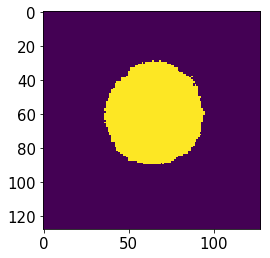

In [14]:
plt.figure()
plt.imshow(util.threshold(PREDS['i2ifc']['y'][0,:,:,0],0.1))
plt.show()

In [14]:
strings = []
dices = []
for code in ERRORS.keys():
    e_d_m = np.mean(ERRORS[code]['dice'])
    e_d_s = np.std(ERRORS[code]['dice'])
    
    e_j_m = np.mean(ERRORS[code]['jaccard'])
    e_j_s = np.std(ERRORS[code]['jaccard'])
    
    e_hd_m = np.mean(ERRORS[code]['hausdorf'])
    e_hd_s = np.std(ERRORS[code]['hausdorf'])
    
    e_assd_m = np.mean(ERRORS[code]['assd'])
    e_assd_s = np.std(ERRORS[code]['assd'])
    
    e_ap_m = np.mean(ERRORS[code]['ap'])
    e_ap_s = np.std(ERRORS[code]['ap'])
    
    s =  "{} & ${:.3f}$ & ${:.3f}$ & ${:.3f}$ & ${:.3f}$ & ${:.3f}$\ \ ".format(code, 
                                                          e_d_m, 
                                                          e_j_m, 
                                                          e_hd_m,
                                                          e_assd_m,
                                                        e_ap_m)
    strings.append(s)
    dices.append(e_d_m)

a = sorted(zip(strings,dices), key = lambda x: x[1])
f = open('2derr_{}.txt'.format(CODE),'w')
print "code, dice, jaccard, hausdorf, assd, ap"
f.write("code, dice, jaccard, hausdorf, assd, ap\n")
for x in a:
    print x[0]
    f.write(x[0]+'\n')
f.close()

code, dice, jaccard, hausdorf, assd, ap
drls_oof & $0.176$ & $0.904$ & $0.728$ & $0.357$ & $0.236$\ \ 
drls & $0.203$ & $0.887$ & $0.726$ & $0.328$ & $0.260$\ \ 
i2i & $0.421$ & $0.733$ & $0.698$ & $0.222$ & $0.536$\ \ 
i2i3d & $0.442$ & $0.717$ & $0.589$ & $0.272$ & $0.451$\ \ 
i2ifc & $0.586$ & $0.585$ & $0.339$ & $0.117$ & $0.620$\ \ 


In [17]:
S = 100

#subsample
for code in ERRORS.keys():
    for PTYPE in ['pr']:
        N = len(ERRORS[code][PTYPE][0])
        ERRORS[code][PTYPE+"_"] = []

        ERRORS[code][PTYPE+'_'].append([ERRORS[code][PTYPE][0][i] for i in range(0,N,S)] + [ERRORS[code][PTYPE][0][N-1]])
        ERRORS[code][PTYPE+'_'].append([ERRORS[code][PTYPE][1][i] for i in range(0,N,S)] + [ERRORS[code][PTYPE][1][N-1]])



In [17]:
from IPython.display import display, Javascript

disable_js = """
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
"""

def disable_scroll():
    display(Javascript(disable_js))
    print ("autoscrolling long output is disabled")
    
disable_scroll()
N=f_test.root.X.shape[0]
f = open('ct_test_list.txt','r').readlines()
for i in range(5):
    
    id_ = np.random.randint(N)
    print id_
    print f[id_]
    img = util.crop_center(f_test.root.X[id_,:,:,0],crop_dims,crop_dims)
    seg = util.crop_center(f_test.root.Y[id_,:,:,0],crop_dims,crop_dims)
    c   = f_test.root.C[id_]
    c_i2ifc = PREDS['i2ifc']['c'][id_]
    
    spacing = f_test.root.meta[i]
    extent = [-64*spacing[0],64*spacing[0],-64*spacing[1],64*spacing[1]]
    
    plt.figure()
    fig, (ax1, ax2, ax3, ax4, ax5, ax6,ax7) = plt.subplots(1, 7, sharey=True,figsize=(12,2))
    ax1.imshow(img,cmap='gray')
    ax2.imshow(seg,cmap='gray')
    ax3.imshow(PREDS['i2ifc']['y'][id_,:,:,0].astype(np.float32))
    ax4.imshow(PREDS['i2i']['y'][id_,:,:,0].astype(np.float32))
    ax5.imshow(PREDS['i2i3d']['y'][id_,:,:,0].astype(np.float32))
    ax6.imshow(PREDS['drls']['y'][id_,:,:,0].astype(np.float32))
    ax7.imshow(PREDS['drls_oof']['y'][id_,:,:,0].astype(np.float32))
    plt.title(f[id_])
    plt.tight_layout
    plt.savefig('../images/images_{}.png'.format(id_),dpi=500)
    plt.show()
    
    
    plt.imshow(img[:,:],cmap='gray',extent=extent)
    plt.plot(c[:,0],c[:,1],color='b',label='truth')
    plt.plot(c_i2ifc[:,0],c_i2ifc[:,1],color='r',label='i2ifc')
    plt.legend()
    plt.colorbar()
    plt.show()
    
    plt.figure()
    plt.imshow(seg,cmap='gray',extent=extent)
    plt.plot(c[:,0],c[:,1],color='b',label='truth')
    plt.plot(c_i2ifc[:,0],c_i2ifc[:,1],color='r',label='i2ifc')
    plt.legend()
    plt.colorbar()
    plt.show()

<IPython.core.display.Javascript object>

autoscrolling long output is disabled
4491


IndexError: list index out of range

In [21]:
%matplotlib inline
from matplotlib import pylab as plt
import numpy as np
import pandas as pd
def plot_f_lines(ax=None,fig_size=None):
    if ax is None:
        fig,ax = plt.subplots(1,1)
    for f in np.array(np.arange(.1,1,.1)):
        r = np.squeeze(np.array([np.arange(f,1.01,.01)]))
        p = np.squeeze(np.array((f*r)/(2*r-f)))
        ax.plot(p,r,color=[0,1,0], linewidth=.5)
        ax.plot(r,p,color=[0,1,0], linewidth=.5);
        ax.set_xlim(0,1);ax.set_ylim(0,1)
        ax.set_xlabel('Recall');ax.set_ylabel('Precision')
        tcks=np.arange(0,1.1,.1)
        tcks_lab = map('{:g}'.format,tcks)
        ax.set_xticks(tcks);ax.set_yticks(tcks)
        ax.set_xticklabels(tcks_lab);ax.set_yticklabels(tcks_lab)
        ax.grid(1);ax.set_aspect('equal')
    if fig_size is not None:
        fig.set_figwidth(fig_size[1]);fig.set_figheight(fig_size[0])
    return fig,ax
def plot_result(R,P,ax=None,label=None, color=None, style='-'):
    print(color)
    if ax is None:
        fig,ax = plt.subplots(1,1)
    if len(R)>1:
        handle = ax.plot(R,P,style,label=label,linewidth=2.5)
    else:
        handle = ax.plot(R,P,'.-',label=label,markersize=20, linewidth=3)
    if color:
        handle[0].set_color(color)
    ax.set_xlim(0,1);ax.set_ylim(0,1)
    ax.set_xlabel('Recall');ax.set_ylabel('Precision')
    tcks=np.arange(0,1.1,.1)
    tcks_lab = map('{:g}'.format,tcks)
    ax.set_xticks(tcks);ax.set_yticks(tcks)
    ax.set_xticklabels(tcks_lab);ax.set_yticklabels(tcks_lab)
    ax.grid(1)

r
g
b
k
y


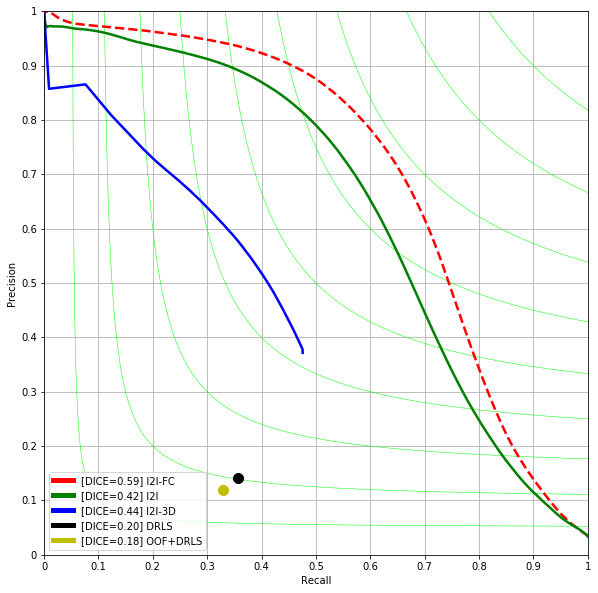

In [22]:
    
fig,ax = plot_f_lines(fig_size=(10,10))
legof = (.5, -0.05)

plot_result(ERRORS['i2ifc']['pr_'][1], ERRORS['i2ifc']['pr_'][0], ax=ax, color='r', 
            label='[DICE={:.2f}] I2I-FC'.format(np.mean(ERRORS['i2ifc']['dice'])),style='--')

plot_result(ERRORS['i2i']['pr_'][1], ERRORS['i2i']['pr_'][0], ax=ax,color='g', 
            label='[DICE={:.2f}] I2I'.format(np.mean(ERRORS['i2i']['dice'])))

plot_result(ERRORS['i2i3d']['pr_'][1][1:], ERRORS['i2i3d']['pr_'][0][1:], ax=ax,color='b', 
            label='[DICE={:.2f}] I2I-3D'.format(np.mean(ERRORS['i2i3d']['dice'])))

plot_result(ERRORS['drls']['pr'][1][1:-1], ERRORS['drls']['pr'][0][1:-1], ax=ax,color='k', 
            label='[DICE={:.2f}] DRLS'.format(np.mean(ERRORS['drls']['dice'])))

plot_result(ERRORS['drls_oof']['pr'][1][1:-1], ERRORS['drls_oof']['pr'][0][1:-1], ax=ax,color='y', 
            label='[DICE={:.2f}] OOF+DRLS'.format(np.mean(ERRORS['drls_oof']['dice'])))

handles, labels = ax.get_legend_handles_labels()
handles2 = [plt.Line2D((0,1),(0,0), color=handle.get_c(), marker='', markersize=20, linestyle='-', linewidth=5) for handle in handles]

ax.legend(handles2,labels,
         ncol=1,loc='lower left', numpoints=1,frameon=True)
plt.show()

fig.savefig('pr_{}.pdf'.format(CODE), bbox_inches='tight')

In [20]:
import pickle
pickle.dump( ERRORS, open( "ERRORS_{}.pkl".format(CODE), "w" ) )